# Rebalancing demo

This notebook demonstrates how to incorporate the rebalancing technique of oversampling into the machine learning pipeline for modelling fraction of precipitation in different intensity bands. This notebook is designed to be run on SPICE, due to the volume of data required during training it will not run locally without memory errors. 

## Set up

Firstly, we import the relevant libraries

In [1]:
import pathlib
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import xarray as xr

In [3]:
import prd_pipeline

AzureML libraries not found, using local execution functions.


Set up MLops for experiment tracking

In [4]:
import mlflow
mlflow.tensorflow.autolog()

In [5]:
tracking_uri = mlflow.get_tracking_uri()
print("Current tracking uri: {}".format(tracking_uri))

Current tracking uri: file:///net/home/h02/hbrown/code/git/precip_rediagnosis/model_pipeline/mlruns


### Load and preprocess data

During data preparation, the fraction of precipitation in a set of intensity band has been calculated. The keys in this dictionary correspond to the bands central value, which has been used within the column names, while the list of two float values correspond to the lower and upper bounds of that band. This band information can also be found in the data prep config files.

In [6]:
bands = {
    '0.0':[0, 0.01],
    '0.25':[0.01, 0.5], 
    '2.5': [0.5, 4], 
    '7.0':[4, 10], 
    '10.0':[10,220]
}

We create a dictionary containing the column names for both model input features and target values. 



In [7]:
intensity_band_template = '{source}_fraction_in_band_instant_{band_centre}'

For profile features, features available in the prepared dataset are: 
- 'air_temperature'
- 'relative_humidity'
- 'wind_speed'
- 'wind_from_direction'
- 'cloud_volume_fraction'
- 'air_pressure'

For single level features, features available in the prepared dataset are:
- 'thickness_of_rainfall_amount'
- 'surface_altitude'
- 'air_pressure_at_sea_level'
- 'cloud_area_fraction'


In [8]:
target_parameter = [intensity_band_template.format(source='radar', band_centre=threshold) for threshold in bands.keys()]
nwp_comparison = [intensity_band_template.format(source='mogrepsg', band_centre=threshold) for threshold in bands.keys()]

profile_features = ['air_temperature', 'relative_humidity', 'wind_speed', 'wind_from_direction', 'cloud_volume_fraction'] 
single_lvl_features = []

In [9]:
feature_dict = {
    'profile': profile_features,
    'single_level': single_lvl_features,
    'target': target_parameter,
    'nwp': nwp_comparison, 
    'metadata': ['time', 'realization', 'latitude', 'longitude']
} 

We load in most of the data, but reserve the first and last scenario in our dataset as unseen test scenarios

In [10]:
dataset_dir = '/project/informatics_lab/precip_rediagnosis/train_202212'
dataset_dir = pathlib.Path(dataset_dir)

prd_path_list = [p1 for p1 in dataset_dir.rglob(f'{prd_pipeline.MERGED_PREFIX}*{prd_pipeline.CSV_FILE_SUFFIX}')]

In [11]:
merged_df = pd.concat([pd.read_csv(p1) for p1 in prd_path_list[1:-1]])

In [12]:
print(f'Filepaths for scenarios reserved for testing:\n {prd_path_list[0]} \n {prd_path_list[-1]}')

Filepaths for scenarios reserved for testing:
 /project/informatics_lab/precip_rediagnosis/train_202212/202002_storm_ciara/prd_merged_20200207T1800Z_20200210T1800Z.csv 
 /project/informatics_lab/precip_rediagnosis/train_202212/2022_storm_eunice_franklin/prd_merged_20220218T1200Z_20220221T1200Z.csv


Now that our data is loaded into a single pandas dataframe, we run preprocessing which split this into train and validate sets, as well as applying scaling to input features and reshaping verticle profile features to reintroduce height dimension.

In [13]:
test_fraction=0.2
data_splits, data_dims_dict = prd_pipeline.preprocess_data(merged_df, feature_dict, test_fraction=test_fraction)

target has dims: 5
dropping datapoints where smallest bin radar_fraction_in_band_instant_0.0 = 1
getting profile columns
{'nprof_features': 5, 'nheights': 33, 'nsinglvl_features': 0, 'nbands': 5}


### Class imbalance

To assess how imbalanced each of our precipiation intensity bands are, we make a copy of the training target dataset and add a column which contains the label for the intensity band with the highest fraction, called max_band. We then print how frequently each of the precip intensity bands has the highest fraction. 

In [14]:
y_train_copy = data_splits['y_train'].copy().reset_index(drop=True)
y_train_copy['max_band'] = y_train_copy.idxmax(axis=1)

In [15]:
y_train_copy['max_band'].value_counts()

radar_fraction_in_band_instant_0.0     352509
radar_fraction_in_band_instant_2.5     209260
radar_fraction_in_band_instant_0.25    164934
radar_fraction_in_band_instant_7.0       7758
radar_fraction_in_band_instant_10.0       252
Name: max_band, dtype: int64

We use resampling to rebalance the dataset. We oversample the less frequent intensity bands and oversample the most frequent intensity bands, to create more uniform distribution within the training data. We also down sample some of the more frequent intensity bands.

n samples = 122452


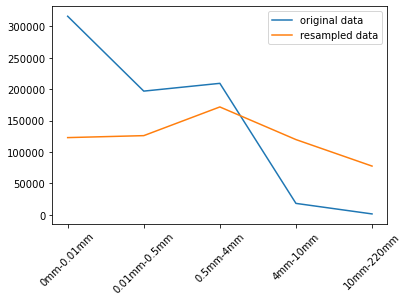

In [16]:
nsamples = len(y_train_copy)//len(y_train_copy.columns)
print('n samples =', nsamples)

y_train = pd.DataFrame()

y_train_copy = y_train_copy.reset_index(drop=True)

for col in y_train_copy.columns[0:-1]:
    ids = y_train_copy[y_train_copy['max_band']==col].index
    
    if len(ids)>0:
        choices = np.random.choice(ids, nsamples)
        y_train = pd.concat([y_train, y_train_copy.loc[choices]])
        try: 
            X_train = np.concatenate([X_train, data_splits['X_train'][choices]])
        except NameError:
            X_train = data_splits['X_train'][choices]

            intensity_bands = [f'{lower_bound}mm-{upper_bound}mm' for lower_bound, upper_bound in bands.values()]

cols = data_splits['y_train'].columns
plt.plot(data_splits['y_train'].sum(axis=0), label='original data')
plt.plot(y_train[cols].sum(axis=0), label='resampled data')
plt.legend()
plt.xticks(np.arange(5), intensity_bands, rotation=45)
plt.show()

y_train = y_train.drop(columns=['max_band'])

data_splits['X_train'] = X_train
data_splits['y_train'] = y_train

## Run experiment

Here we train and evaluate our model. All parameters and the output model will be logged through MLFlow.

First we check whether our MLFlow experiment already exists, if it does then we assign the experiment to a variable, if not we create an experiment.

In [17]:
exp_name='prd_fraction_models_mlflow'
try:
    exp1 = mlflow.create_experiment(exp_name)
except:
    exp1 = mlflow.get_experiment_by_name(exp_name)
exp1

<Experiment: artifact_location='file:///net/home/h02/hbrown/code/git/precip_rediagnosis/model_pipeline/mlruns/4', experiment_id='4', lifecycle_stage='active', name='prd_fraction_models_mlflow', tags={}>

Create a dictionary containing our model hyperparameters

In [18]:
hyperparameter_dict = {
    'epochs': 10, 
    'learning_rate': 0.001, 
    'batch_size': 64,  
    'loss': tf.keras.losses.KLDivergence()
}

Now we create a model run within the MLFlow experiment from above, then run model training. In doing so all metrics and hyperparamters from model training will be tracked. We can also manually log parameters and metrics, such as model input features. 

In [19]:
with mlflow.start_run(experiment_id=exp1.experiment_id) as current_run:
    mlflow.log_param('features', feature_dict['profile'] + feature_dict['single_level'])    
    model = prd_pipeline.build_model(**data_dims_dict)
    model.summary()
    model, history = prd_pipeline.train_model(model, data_splits, hyperparameter_dict, log_dir='./logs')

2022-12-19 09:16:53.827221: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 profile_input (InputLayer)     [(None, 33, 5)]      0           []                               
                                                                                                  
 zero_padding1d (ZeroPadding1D)  (None, 35, 5)       0           ['profile_input[0][0]']          
                                                                                                  
 conv1d (Conv1D)                (None, 33, 32)       480         ['zero_padding1d[0][0]']         
                                                                                                  
 zero_padding1d_1 (ZeroPadding1  (None, 35, 32)      0           ['conv1d[0][0]']                 
 D)                                                                                           

2022-12-19 09:23:22.330064: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /var/tmp/tmpn3ej07u3/model/data/model/assets


Once model training is completed, we quickly plot comparisons of training and validation loss and accuracy curves, to check whether our model has started to converge and is therefore learning from our data.  

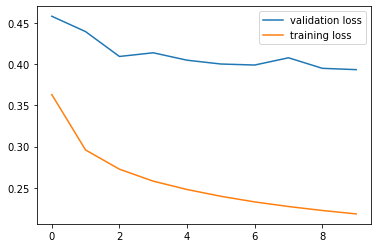

In [20]:
plt.plot(range(hyperparameter_dict['epochs']), history.history['val_loss'], label='validation loss')
plt.plot(range(hyperparameter_dict['epochs']), history.history['loss'], label='training loss')
plt.legend()
plt.show()

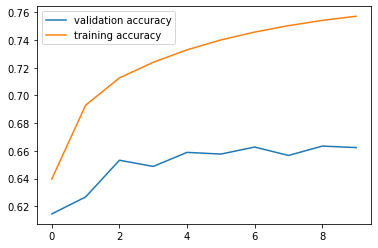

In [21]:
plt.plot(range(hyperparameter_dict['epochs']), history.history['val_accuracy'], label='validation accuracy')
plt.plot(range(hyperparameter_dict['epochs']), history.history['accuracy'], label='training accuracy')
plt.legend()
plt.show()

## Inference and model evaluation

Now that a model has been trained, we can use the validation dataset to assess how this model is performing. We create predictions from our model using validation model inputs.

In [22]:
y_pred = model.predict(data_splits['X_val'])

We put our validation prediction into a pandas DataFrame to ease model assessment. 

In [23]:
pred_column_names = [intensity_band_template.format(source='ml', band_centre=threshold) for threshold in bands.keys()]
y_pred_df = pd.DataFrame(y_pred, columns=pred_column_names)

evaluation_df = pd.concat([
    data_splits['meta_val'].reset_index(drop=True), 
    data_splits['nwp_val'].reset_index(drop=True), 
    data_splits['y_val'].reset_index(drop=True), 
    y_pred_df], axis=1)

We then use the Fractional Skill Score to assess model performance. This metrics requires us to transform the data to fraction exceeding thresholds, to do this take the cumulative sum of fractions in all bands with upper bound below or including the thresholds then subtraction from one. 

In [24]:
source = ['radar', 'mogrepsg', 'ml']
for src in source:
    evaluation_df = prd_pipeline.calculate_p_exceedance(evaluation_df, src, bands, intensity_band_template)

Due to rounding error, some datapoints have very small negative probability of exceedance. In these cases we reassign negative values as zero. We then calculate the fractional skill score to compare both NWP probability and ML fraction prediction with radar. We can then compare how well machine learning and NWP perform for different precipitation thresholds. 

For each upper bound in our set of precipiation intensity bands, we calculate the fractional skill score for exceeding that threshold. Firstly, we treat each ML prediction produced by each ensemble member as a deterministic forecast. 

In [25]:
for threshold in bands.keys():
   
    ml_data = evaluation_df[f'ml_fraction_in_band_instant_{threshold}_exceedence']
    ml_data[ml_data<0]=0
    
    nwp_data = evaluation_df[f'mogrepsg_fraction_in_band_instant_{threshold}_exceedence']
    nwp_data[nwp_data<0]=0
    
    radar_data = evaluation_df[f'radar_fraction_in_band_instant_{threshold}_exceedence']
    radar_data[radar_data<0]=0
    
    print(f'ML FSS - P(precip>{bands[threshold][1]}mm): {prd_pipeline.fss(radar_data, ml_data):.4f}')
    print(f'NWP FSS - P(precip>{bands[threshold][1]}mm): {prd_pipeline.fss(radar_data, nwp_data):.4f}')

ML FSS - P(precip>0.01mm): 0.9156
NWP FSS - P(precip>0.01mm): 0.8293
ML FSS - P(precip>0.5mm): 0.8501
NWP FSS - P(precip>0.5mm): 0.7376
ML FSS - P(precip>4mm): 0.6336
NWP FSS - P(precip>4mm): 0.2068
ML FSS - P(precip>10mm): 0.3895
NWP FSS - P(precip>10mm): 0.0006
ML FSS - P(precip>220mm): 0.0000
NWP FSS - P(precip>220mm): 0.1781


We now take the average of the ML prediction made for each ensemble member at the same time and location, and calculate fractional skill score for these average values.

In [26]:
# Calculate FSS for mean of ML prediction from set of ens members
grouped = evaluation_df.groupby(['time', 'latitude', 'longitude']).agg('mean')
for threshold in bands.keys():

    ml_data = grouped[f'ml_fraction_in_band_instant_{threshold}_exceedence']
    ml_data[ml_data<0]=0
    
    nwp_data = grouped[f'mogrepsg_fraction_in_band_instant_{threshold}_exceedence']
    nwp_data[nwp_data<0]=0
    
    radar_data = grouped[f'radar_fraction_in_band_instant_{threshold}_exceedence']
    radar_data[radar_data<0]=0
    
    print(f'ML FSS - P(precip>{bands[threshold][1]}mm): {prd_pipeline.fss(radar_data, ml_data):.4f}')
    print(f'NWP FSS - P(precip>{bands[threshold][1]}mm): {prd_pipeline.fss(radar_data, nwp_data):.4f}')

ML FSS - P(precip>0.01mm): 0.9279
NWP FSS - P(precip>0.01mm): 0.8293
ML FSS - P(precip>0.5mm): 0.8795
NWP FSS - P(precip>0.5mm): 0.7376
ML FSS - P(precip>4mm): 0.7209
NWP FSS - P(precip>4mm): 0.2068
ML FSS - P(precip>10mm): 0.4498
NWP FSS - P(precip>10mm): 0.0006
ML FSS - P(precip>220mm): -0.0000
NWP FSS - P(precip>220mm): 0.1781
